# Reinforcement Learning for the Inverted Pendulum

Perform approximate policy iteration in an actor-critic framework for the inverted pendulum.

In [1]:
from __future__ import division, print_function

import numpy as np
import tensorflow as tf
import gpflow
import safe_learning
import matplotlib.pyplot as plt
import time
import os

from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import block_diag
from utilities import InvertedPendulum, compute_closedloop_response, get_parameter_change, binary_cmap, compute_roa, reward_rollout

# Nice progress bars
try:
    from tqdm import tqdm
except ImportError:
    tqdm = lambda x: x



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



## User Options

In [2]:
class Options(object):
    def __init__(self, **kwargs):
        super(Options, self).__init__()
        self.__dict__.update(kwargs)

OPTIONS = Options(np_dtype              = safe_learning.config.np_dtype,
                  tf_dtype              = safe_learning.config.dtype,
                  saturate              = True,                            # apply saturation constraints to the control input
                  eps                   = 1e-8,                            # numerical tolerance
                  use_linear_dynamics   = False,                           # use the linearized form of the dynamics as the true dynamics (for testing)
                  dpi                   = 200,
                  num_cores             = 4,
                  num_sockets           = 1)


## TensorFlow Session

Customize the TensorFlow session for the current device.

In [3]:
os.environ["KMP_BLOCKTIME"]    = str(0)
os.environ["KMP_SETTINGS"]     = str(1)
os.environ["KMP_AFFINITY"]     = 'granularity=fine,noverbose,compact,1,0'
os.environ["OMP_NUM_THREADS"]  = str(OPTIONS.num_cores)

config = tf.ConfigProto(intra_op_parallelism_threads  = OPTIONS.num_cores,
                        inter_op_parallelism_threads  = OPTIONS.num_sockets,
                        allow_soft_placement          = False,
                        device_count                  = {'CPU': OPTIONS.num_cores})

try:
    session.close()
except NameError:
    pass
session = tf.InteractiveSession(config=config)


## Dynamics

Define the nonlinear and linearized forms of the inverted pendulum dynamics.

In [4]:
# Constants
dt = 0.01   # sampling time
g = 9.81    # gravity

# System parameters
m = 0.15    # pendulum mass
L = 0.5     # pole length
b = 0.1     # rotational friction

# State and action normalizers
theta_max = np.deg2rad(30)                 # angular position [rad]
omega_max = np.sqrt(g / L)                 # angular velocity [rad/s]
u_max     = g * m * L * np.sin(theta_max)  # torque [N.m], control action

state_norm = (theta_max, omega_max)
action_norm = (u_max, )

# Dimensions and domains
state_dim     = 2
action_dim    = 1
state_limits  = np.array([[-1., 1.]] * state_dim)
action_limits = np.array([[-1., 1.]] * action_dim)

# Initialize system class and its linearization
pendulum = InvertedPendulum(m, L, b, dt, [state_norm, action_norm])
A, B = pendulum.linearize()

if OPTIONS.use_linear_dynamics:
    dynamics = safe_learning.functions.LinearSystem((A, B), name='dynamics')
else:
    dynamics = pendulum.__call__


## Reward Function

Define a positive-definite reward function over the state-action space $\mathcal{X} \times \mathcal{U}$.

In [5]:
Q = 0.1 * np.identity(state_dim).astype(OPTIONS.np_dtype)     # state cost matrix
R = 0.1 * np.identity(action_dim).astype(OPTIONS.np_dtype)    # action cost matrix

# Quadratic reward (- cost) function
reward_function = safe_learning.QuadraticFunction(block_diag(- Q, - R), name='reward_function')


## Parametric Policy and Value Function

Define a parametric value function $V_{\bf \theta} : \mathcal{X} \to \mathbb{R}$ and policy $\pi_{\bf \delta} : \mathcal{X} \to \mathcal{U}$ as neural networks.

In [6]:
# Policy
layer_dims = [64, 64, action_dim]
activations = [tf.nn.relu, tf.nn.relu, None]
if OPTIONS.saturate:
    activations[-1] = tf.nn.tanh
# Remove bias terms to ensure the policy maps the zero state to the zero input
policy = safe_learning.functions.NeuralNetwork(layer_dims, activations, name='policy', use_bias=False)

# Value function
layer_dims = [64, 64, 1]
activations = [tf.nn.relu, tf.nn.relu, None]
value_function = safe_learning.functions.NeuralNetwork(layer_dims, activations, name='value_function', use_bias=True)


---
## Approximate Policy Evaluation

Fix the policy, and learn the corresponding value function.

### Fixed Policy

Fix the policy $\pi$ to the LQR solution for the linearized system, possibly with saturation constraints

In [7]:
K, P = safe_learning.utilities.dlqr(A, B, Q, R)
policy_lqr = safe_learning.functions.LinearSystem((-K, ), name='policy_lqr')
if OPTIONS.saturate:
    policy_lqr = safe_learning.Saturation(policy_lqr, -1, 1)


/app/safe_learning/functions.py:1563: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  self.matrix = np.hstack(map(fun, matrices))


### TensorFlow Graph

In [8]:
# Define new graph
states = tf.placeholder(OPTIONS.tf_dtype, shape=[None, state_dim], name='states')
actions = policy_lqr(states)
rewards = reward_function(states, actions)
future_states = dynamics(states, actions)

# Use the parametric value function
values = value_function(states)
future_values = value_function(future_states)

with tf.name_scope('approximate_policy_evaluation'):
    # Discount factor and scaling
    gamma = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='discount_factor')
    max_state = np.ones((1, state_dim))
    max_action = np.ones((1, action_dim))
    r_max = np.linalg.multi_dot((max_state, Q, max_state.T)) + np.linalg.multi_dot((max_action, R, max_action.T))
#     scaling = (1 - gamma) / r_max.ravel()
    scaling = 1 / r_max.ravel()
    
    # Objective function
    target = tf.stop_gradient(rewards + gamma * future_values, name='target')
    objective = scaling * tf.reduce_mean(tf.abs(values - target), name='objective')
    
    # Optimizer settings
    learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_update = optimizer.minimize(objective, var_list=value_function.parameters)
    
with tf.name_scope('state_sampler'):
    batch_size = tf.placeholder(tf.int32, shape=[], name='batch_size')
    batch = tf.random_uniform([batch_size, state_dim], -1, 1, dtype=OPTIONS.tf_dtype, name='batch')


Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Please use `layer.__call__` method instead.


### Value Function Initialization

In [9]:
session.run(tf.variables_initializer(value_function.parameters))

# Uniformly sampled test set
test_size = 1e3
test_set = batch.eval({batch_size: test_size})

# Keep track of the test set loss and parameter changes during training
test_loss = []
param_changes = []


### Training

Changing the discount factor affects the results immensely, due to the effect of diverging trajectories on the value function.

In [10]:
# Training hyperparameters
feed_dict = {
    states:         np.zeros((1, state_dim)), # placeholder
    gamma:          0.95,
    learning_rate:  0.005,
    batch_size:     100,   
}
max_iters = 500

old_params = session.run(value_function.parameters)
for _ in tqdm(range(max_iters)):
    feed_dict[states] = batch.eval(feed_dict)
    session.run(training_update, feed_dict)
    
    new_params = session.run(value_function.parameters)
    param_changes.append(get_parameter_change(old_params, new_params, 'inf'))
    old_params = list(new_params)
    
    feed_dict[states] = test_set
    test_loss.append(objective.eval(feed_dict))


### Training Results

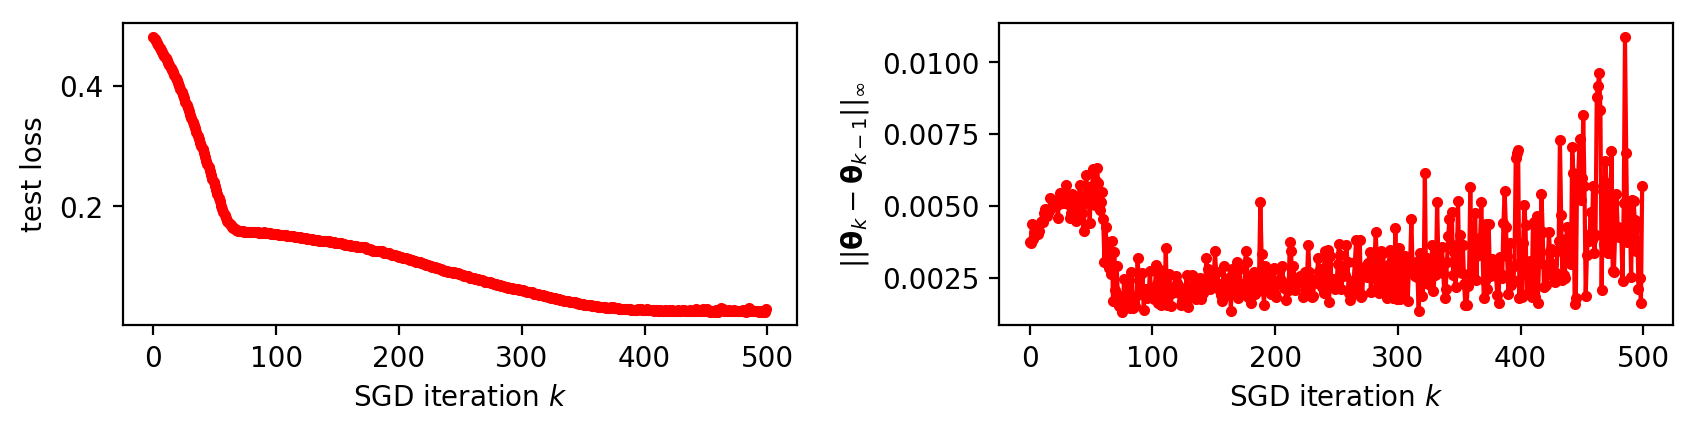

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2), dpi=OPTIONS.dpi)
fig.subplots_adjust(wspace=0.3)

axes[0].plot(test_loss, '.-r')
axes[0].set_xlabel(r'SGD iteration $k$')
axes[0].set_ylabel(r'test loss')

axes[1].plot(param_changes, '.-r')
axes[1].set_xlabel(r'SGD iteration $k$')
axes[1].set_ylabel(r'$||{\bf \theta}_k - {\bf \theta}_{k-1}||_\infty$')

plt.show()


### True Dynamics: Trajectories, ROA, and Value Function

Compute the true largest region of attraction (ROA) by forward-simulating the closed-loop dynamics on a state space grid. Also, compute the true value function $V_\pi$ on this grid by summing discounted rewards along these forward-simulated trajectories.

In [12]:
# Number of states along each dimension
num_states = 101

# State grid
grid_limits = np.array([[-1., 1.], ] * state_dim)
grid = safe_learning.GridWorld(grid_limits, num_states)

# ROA and closed-loop dynamics
closed_loop_dynamics = lambda x: future_states.eval({states: x})
horizon = 500
tol = 1e-2
roa, trajectories = compute_roa(grid, closed_loop_dynamics, horizon, tol, no_traj=False)

# Estimate true value function with a reward rollout
reward_eval = lambda x: rewards.eval({states: x})
discount = feed_dict[gamma]
horizon = 1000
tol = 1e-2
true_values = reward_rollout(grid, closed_loop_dynamics, reward_eval, discount, horizon, tol)


/app/safe_learning/functions.py:635: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points = np.column_stack(col.ravel() for col in mesh)


Reward sums converged after 115 steps!


### Plotting

Visually compare the true value function $V_\pi$ and the neural network $V_{\bf \theta}$.

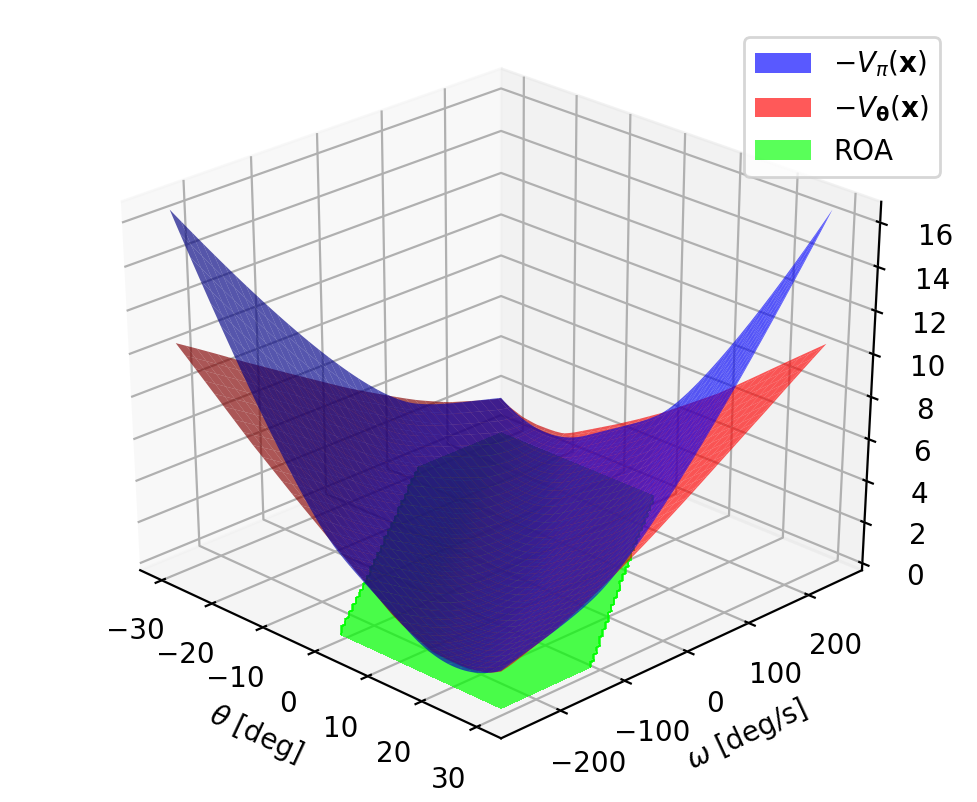

In [13]:
fig = plt.figure(figsize=(6, 5), dpi=OPTIONS.dpi)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\omega$ [deg/s]')

scaled_discrete_points = [norm * points for norm, points in zip(np.rad2deg(state_norm), grid.discrete_points)]
xx, yy = np.meshgrid(*scaled_discrete_points)

# ROA
z = roa.reshape(grid.num_points)
ax.contourf(xx, yy, z, cmap=binary_cmap('green', 0.7), zdir='z', offset=0)

# Cost (- value) functions
z = - true_values.reshape(grid.num_points)
surf_true = ax.plot_surface(xx, yy, z, color='b', alpha=0.65)

z = - values.eval({states: grid.all_points}).reshape(grid.num_points)
surf_approx = ax.plot_surface(xx, yy, z, color='r', alpha=0.65)

for surf in (surf_true, surf_approx):
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d

# Legend
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in [(0., 0., 1., 0.65), (1., 0., 0., 0.65), (0., 1., 0., 0.65)]]    
ax.legend(proxy, [r'$-V_{\pi}({\bf x})$', r'$-V_{\bf \theta}({\bf x})$', 'ROA'])

ax.view_init(None, -45)

plt.show()


---
## Approximate Policy Improvement

Fix the value function, and learn the corresponding policy. Changing the discount factor affects the results immensely, due to the effect of diverging trajectories on the value function. However, a high discount factor encourages the policy to yield a large ROA for the closed-loop system.

In [14]:
discount = 0.965


### Fixed Value Function

Use supervised learning to closely approximate a fixed value function with a neural network.

In [15]:
horizon = 1000
tol = 1e-2
true_values = reward_rollout(grid, closed_loop_dynamics, reward_eval, discount, horizon, tol)


Reward sums converged after 164 steps!


In [16]:
with tf.name_scope('supervised_value_function_learning'):
    tf_true_values = tf.placeholder(OPTIONS.tf_dtype, shape=[None, 1], name='true_values')
    loss = tf.abs(values - tf_true_values)
    objective = tf.reduce_mean(loss, name='objective')
    
    learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_update = optimizer.minimize(objective, var_list=value_function.parameters)

test_set = grid.all_points
test_values = true_values.reshape((-1, 1))
test_loss = []

In [17]:
# Feed dict with hyperparameters
feed_dict = {
    states:         np.zeros((1, state_dim)), # placeholder
    tf_true_values: np.zeros((1, 1)),         # placeholder
    learning_rate:  0.005
}
max_iters  = 1000
batch_size = 1000

for i in tqdm(range(max_iters)):
    batch_idx = np.random.randint(grid.nindex, size=batch_size)
    feed_dict[states] = grid.all_points[batch_idx]
    feed_dict[tf_true_values] = true_values[batch_idx].reshape((-1, 1))
    session.run(training_update, feed_dict)
    
    feed_dict[states] = test_set
    feed_dict[tf_true_values] = test_values
    test_loss.append(objective.eval(feed_dict))


### TensorFlow Graph

In [18]:
# Use the parametric policy
states = tf.placeholder(OPTIONS.tf_dtype, shape=[None, state_dim], name='states')
actions = policy(states)
rewards = reward_function(states, actions)
future_states = dynamics(states, actions)

# Future values according to parametric policy and true value function
future_values = value_function(future_states)

with tf.name_scope('approximate_policy_evaluation'):
    # Discount factor and scaling
    gamma = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='discount_factor')
    max_state = np.ones((1, state_dim))
    max_action = np.ones((1, action_dim))
    r_max = np.linalg.multi_dot((max_state, Q, max_state.T)) + np.linalg.multi_dot((max_action, R, max_action.T))
    scaling = (1 - gamma) / r_max.ravel()
    
    # Objective function    
    objective = - scaling * tf.reduce_mean(rewards + gamma * future_values, name='objective')
    
    # Optimizer settings
    learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_update = optimizer.minimize(objective, var_list=policy.parameters)
    
with tf.name_scope('state_sampler'):
    batch_size = tf.placeholder(tf.int32, shape=[], name='batch_size')
    batch = tf.random_uniform([batch_size, state_dim], -1, 1, dtype=OPTIONS.tf_dtype, name='batch')


### Policy Initialization

In [19]:
session.run(tf.variables_initializer(policy.parameters))

# Uniformly sampled test set
test_size = 1e3
test_set = batch.eval({batch_size: test_size})

# Keep track of the test set loss and parameter changes during training
test_loss = []
param_changes = []


### Training

In [20]:
# Feed dict with hyperparameters
feed_dict = {
    states:         np.zeros((1, state_dim)), # placeholder
    gamma:          discount,                 # use the same discount factor from the value function!
    learning_rate:  0.6,
    batch_size:     100,   
}
max_iters = 1000

old_params = session.run(policy.parameters)
for i in tqdm(range(max_iters)):
    feed_dict[states] = batch.eval(feed_dict)
    session.run(training_update, feed_dict)
    
    new_params = session.run(policy.parameters)
    param_changes.append(get_parameter_change(old_params, new_params, 'inf'))
    old_params = list(new_params)
    
    feed_dict[states] = test_set
    test_loss.append(objective.eval(feed_dict))


### Training Results

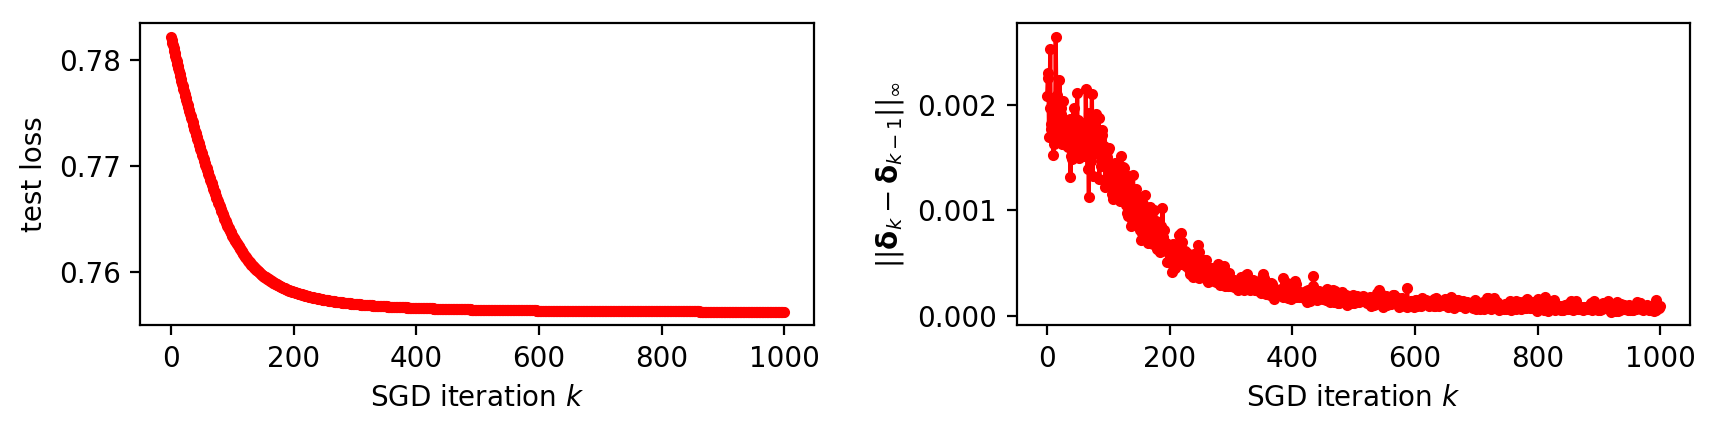

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2), dpi=OPTIONS.dpi)
fig.subplots_adjust(wspace=0.3)

axes[0].plot(test_loss, '.-r')
axes[0].set_xlabel(r'SGD iteration $k$')
axes[0].set_ylabel(r'test loss')

axes[1].plot(param_changes, '.-r')
axes[1].set_xlabel(r'SGD iteration $k$')
axes[1].set_ylabel(r'$||{\bf \delta}_k - {\bf \delta}_{k-1}||_\infty$')

plt.show()


### Plotting

Visually compare the true policy $\pi$ and the neural network $\pi_{\bf \delta}$.

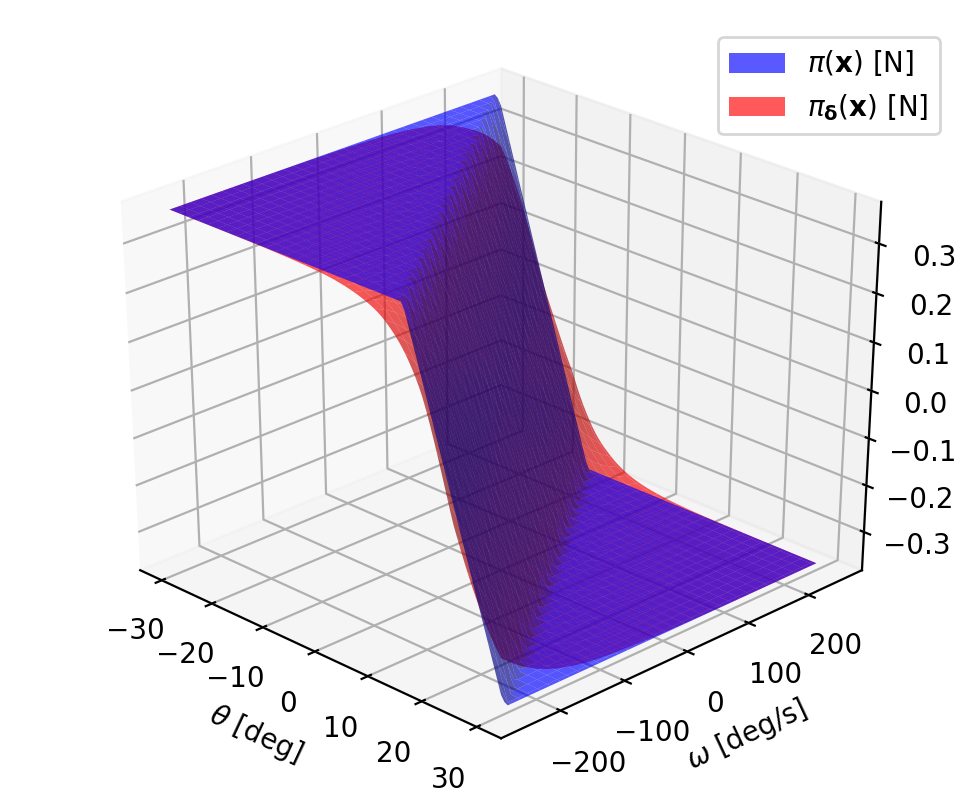

In [22]:
fig = plt.figure(figsize=(6, 5), dpi=OPTIONS.dpi)
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\omega$ [deg/s]')
    
# Policies
approx = u_max * actions.eval({states: grid.all_points}).reshape(grid.num_points)
truth = u_max * policy_lqr(grid.all_points).eval().reshape(grid.num_points)
for zz, c in zip([approx, truth], ['r', 'b']):
    surf = ax.plot_surface(xx, yy, zz, color=c, alpha=0.65)
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d

# Legend
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in [(0., 0., 1., 0.65), (1., 0., 0., 0.65)]]    
ax.legend(proxy, [r'$\pi({\bf x})$ [N]', r'$\pi_{\bf \delta}({\bf x})$ [N]'])
ax.view_init(None, -45)

plt.show()


### New ROA

Visually compare the new ROA yielded by the parametric policy to the one yielded by the LQR policy, possibly with saturation constraints.

In [23]:
closed_loop_dynamics = lambda x: future_states.eval({states: x})
roa_horizon = 600
tol = 0.1
new_roa, new_trajectories = compute_roa(grid, closed_loop_dynamics, roa_horizon, tol, equilibrium=None, no_traj=False)


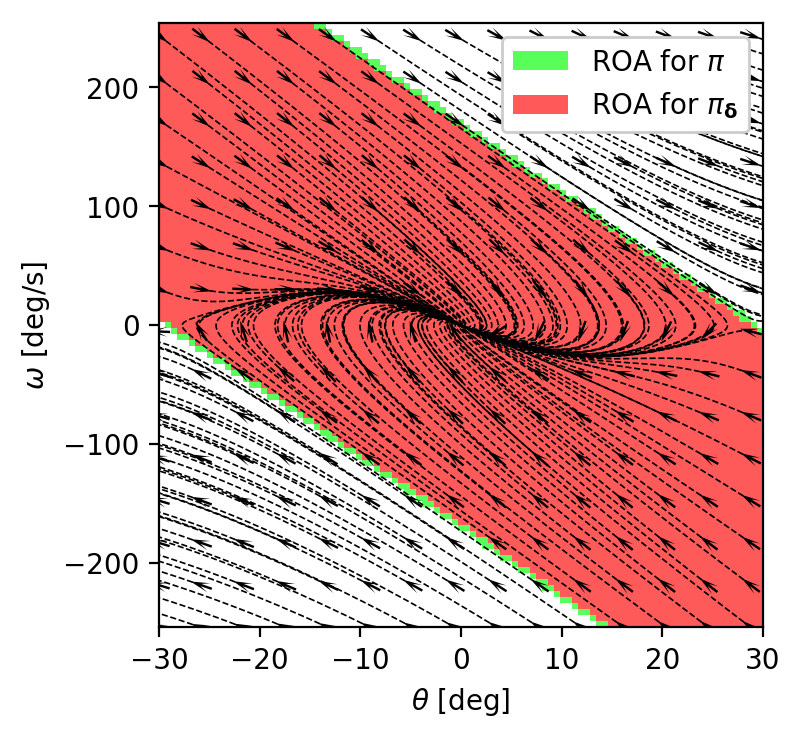

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=OPTIONS.dpi)

norms = np.rad2deg(state_norm)
plot_limits = np.column_stack((- norms, norms))
ax.set_aspect(norms[0] / norms[1])
ax.set_xlim(plot_limits[0])
ax.set_ylim(plot_limits[1])
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\omega$ [deg/s]')
    
# Compare ROAs
cmap = ListedColormap([(1., 1., 1., 0.), (0., 1., 0., 0.65), (1., 0., 0., 0.65)])
z = (roa.astype(int) + new_roa.astype(int)).reshape(grid.num_points)
im = ax.imshow(z.T, origin='lower', extent=plot_limits.ravel(), aspect=norms[0] / norms[1], cmap=cmap)

# Sub-sample discretization for faster and clearer plotting
N_traj = 13
skip = int(grid.num_points[0] / N_traj)
sub_idx = np.arange(grid.nindex).reshape(grid.num_points)
sub_idx = sub_idx[::skip, ::skip].ravel()
sub_trajectories = new_trajectories[sub_idx, :, :]

# Trajectories
for n in range(sub_trajectories.shape[0]):
    theta = sub_trajectories[n, 0, :] * norms[0]
    omega = sub_trajectories[n, 1, :] * norms[1]
    ax.plot(theta, omega, 'k--', linewidth=0.6)
sub_states = grid.all_points[sub_idx]
dx_dt = (future_states.eval({states: sub_states}) - sub_states) / dt
dx_dt = dx_dt / np.linalg.norm(dx_dt, ord=2, axis=1, keepdims=True)
ax.quiver(sub_states[:, 0] * norms[0], sub_states[:, 1] * norms[1], dx_dt[:, 0], dx_dt[:, 1], scale=None, pivot='mid', headwidth=4, headlength=8, color='k')

# Legend
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in [(0., 1., 0., 0.65), (1., 0., 0., 0.65)]]    
legend = ax.legend(proxy, [r'ROA for $\pi$', r'ROA for $\pi_{\bf \delta}$'], loc='upper right')
legend.get_frame().set_alpha(1.)

plt.show()


---
## Approximate Policy Iteration

Train the policy $\pi_{\bf \delta}$ and value function $V_{\bf \theta}$ in tandem with approximate policy iteration. Once again, changing the discount factor strongly affects the results. A low discount factor encourages a well-behaved value function, while a high discount factor encourages the policy to yield a larger ROA.

### TensorFlow Graph

In [26]:
# Use parametric policy and value function
states = tf.placeholder(OPTIONS.tf_dtype, shape=[None, state_dim], name='states')
actions = policy(states)
rewards = reward_function(states, actions)
values = value_function(states)
future_states = dynamics(states, actions)
future_values = value_function(future_states)

# Compare with LQR solution, possibly with saturation constraints
actions_lqr = policy_lqr(states)
rewards_lqr = reward_function(states, actions_lqr)
future_states_lqr = dynamics(states, actions_lqr)

# Discount factor and scaling
max_state = np.ones((1, state_dim))
max_action = np.ones((1, action_dim))
r_max = np.linalg.multi_dot((max_state, Q, max_state.T)) + np.linalg.multi_dot((max_action, R, max_action.T))
gamma = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='discount_factor')
eval_scaling = 1 / r_max.ravel()
impv_scaling = (1 - gamma) / r_max.ravel()

# Policy evaluation
with tf.name_scope('value_optimization'):
    value_learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
    target = tf.stop_gradient(rewards + gamma * future_values, name='target')
    value_objective = eval_scaling * tf.reduce_mean(tf.abs(values - target), name='objective')
    optimizer = tf.train.GradientDescentOptimizer(value_learning_rate)
    value_update = optimizer.minimize(value_objective, var_list=value_function.parameters)

# Policy improvement
with tf.name_scope('policy_optimization'):
    policy_learning_rate = tf.placeholder(OPTIONS.tf_dtype, shape=[], name='learning_rate')
    policy_objective = - impv_scaling * tf.reduce_mean(rewards + gamma * future_values, name='objective')
    optimizer = tf.train.GradientDescentOptimizer(policy_learning_rate)
    policy_update = optimizer.minimize(policy_objective, var_list=policy.parameters)

# Sampling    
with tf.name_scope('state_sampler'):
    batch_size = tf.placeholder(tf.int32, shape=[], name='batch_size')
    batch = tf.random_uniform([batch_size, state_dim], -1, 1, dtype=OPTIONS.tf_dtype, name='batch')


### Policy and Value Function Initialization

In [28]:
# Initialize parameters
session.run(tf.variables_initializer(value_function.parameters))
session.run(tf.variables_initializer(policy.parameters))

# Uniformly sampled test set
test_size = 1e3
test_set = batch.eval({batch_size: test_size})

# Keep track of the test set losses and parameter changes during training
value_test_loss = []
value_param_changes = []

policy_test_loss = []
policy_param_changes = []


## Training

In [29]:
# Feed dict with hyperparameters
feed_dict = {
    states:                np.zeros((1, state_dim)), # placeholder
    gamma:                 0.965,
    value_learning_rate:   0.005,
    policy_learning_rate:  0.6,
    batch_size:            int(1e2),
}
max_iters    = 200
value_iters  = 100
policy_iters = 10

old_value_params = session.run(value_function.parameters)
old_policy_params = session.run(policy.parameters)

for i in tqdm(range(max_iters)):
    
    # Policy evaluation (value function update)
    for _ in range(value_iters):
        feed_dict[states] = batch.eval(feed_dict)
        session.run(value_update, feed_dict)
        #
    feed_dict[states] = test_set
    value_test_loss.append(value_objective.eval(feed_dict))
    new_value_params = session.run(value_function.parameters)
    value_param_changes.append(get_parameter_change(old_value_params, new_value_params, 'inf'))
    old_value_params = list(new_value_params)

    # Policy improvement (policy update)
    for _ in range(policy_iters):
        feed_dict[states] = batch.eval(feed_dict)
        session.run(policy_update, feed_dict)
        #
    feed_dict[states] = test_set
    policy_test_loss.append(policy_objective.eval(feed_dict))
    new_policy_params = session.run(policy.parameters)
    policy_param_changes.append(get_parameter_change(old_policy_params, new_policy_params, 'inf'))
    old_policy_params = list(new_policy_params)


### Results

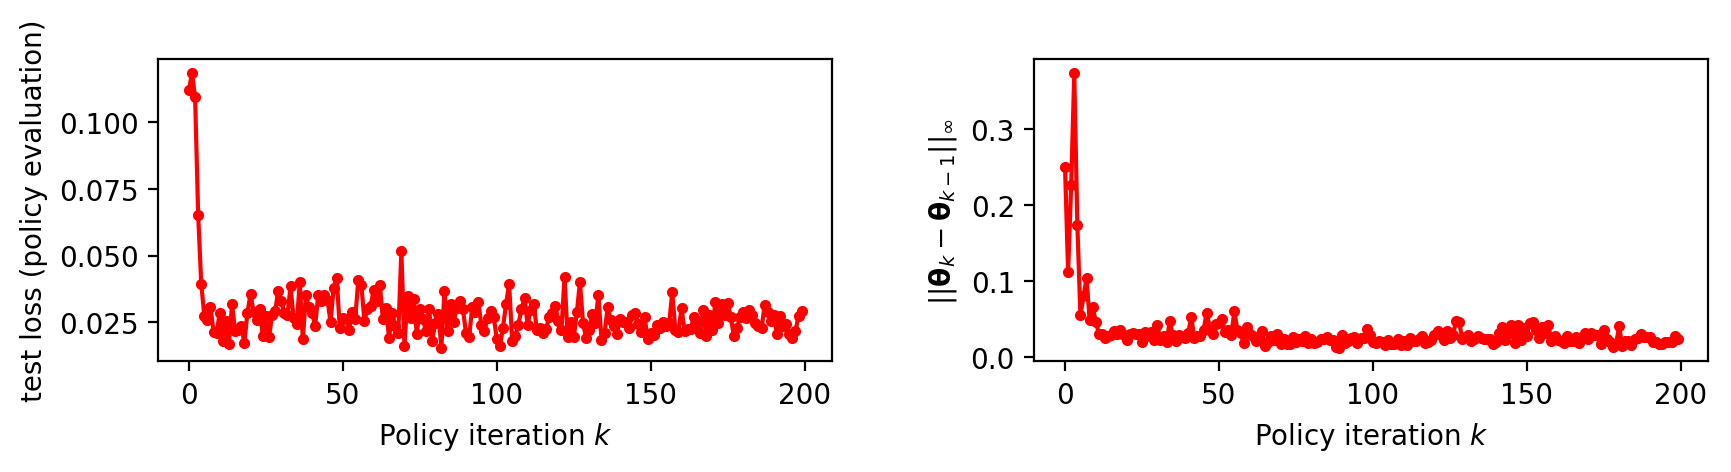

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2), dpi=OPTIONS.dpi)
fig.subplots_adjust(wspace=0.3)

axes[0].plot(value_test_loss, '.-r')
axes[0].set_xlabel(r'Policy iteration $k$')
axes[0].set_ylabel(r'test loss (policy evaluation)')

axes[1].plot(value_param_changes, '.-r')
axes[1].set_xlabel(r'Policy iteration $k$')
axes[1].set_ylabel(r'$||{\bf \theta}_k - {\bf \theta}_{k-1}||_\infty$')

plt.show()


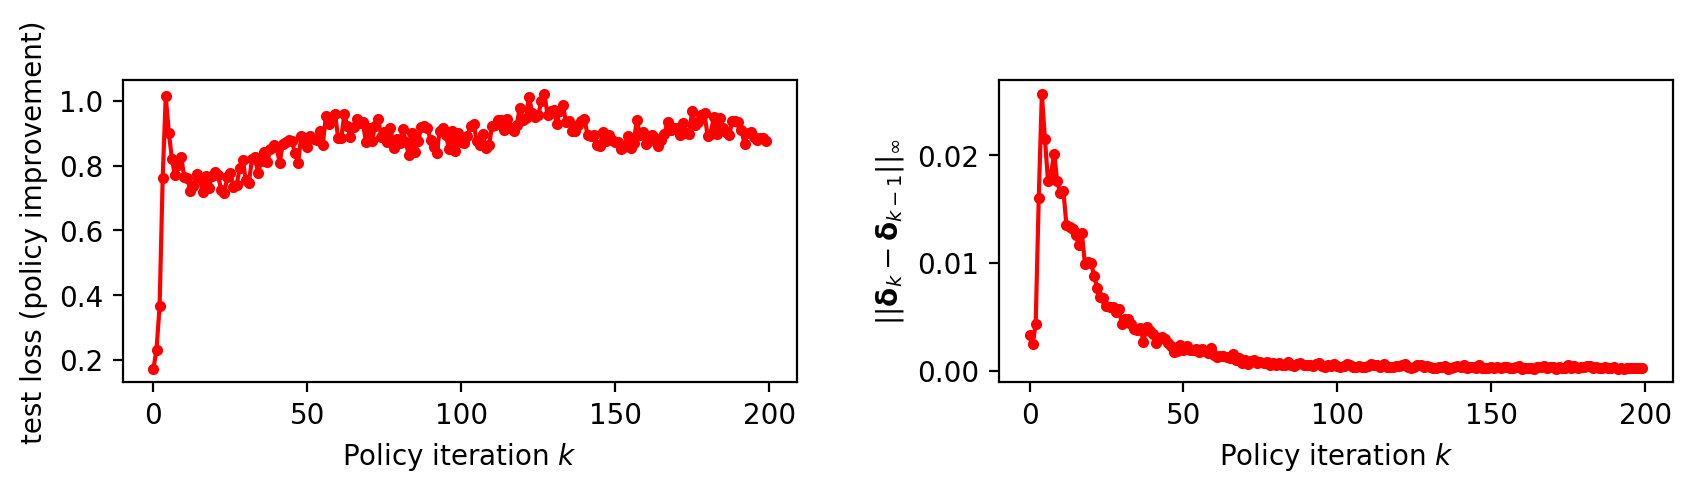

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(10, 2), dpi=OPTIONS.dpi)
fig.subplots_adjust(wspace=0.3)

axes[0].plot(policy_test_loss, '.-r')
axes[0].set_xlabel(r'Policy iteration $k$')
axes[0].set_ylabel(r'test loss (policy improvement)')

axes[1].plot(policy_param_changes, '.-r')
axes[1].set_xlabel(r'Policy iteration $k$')
axes[1].set_ylabel(r'$||{\bf \delta}_k - {\bf \delta}_{k-1}||_\infty$')

plt.show()


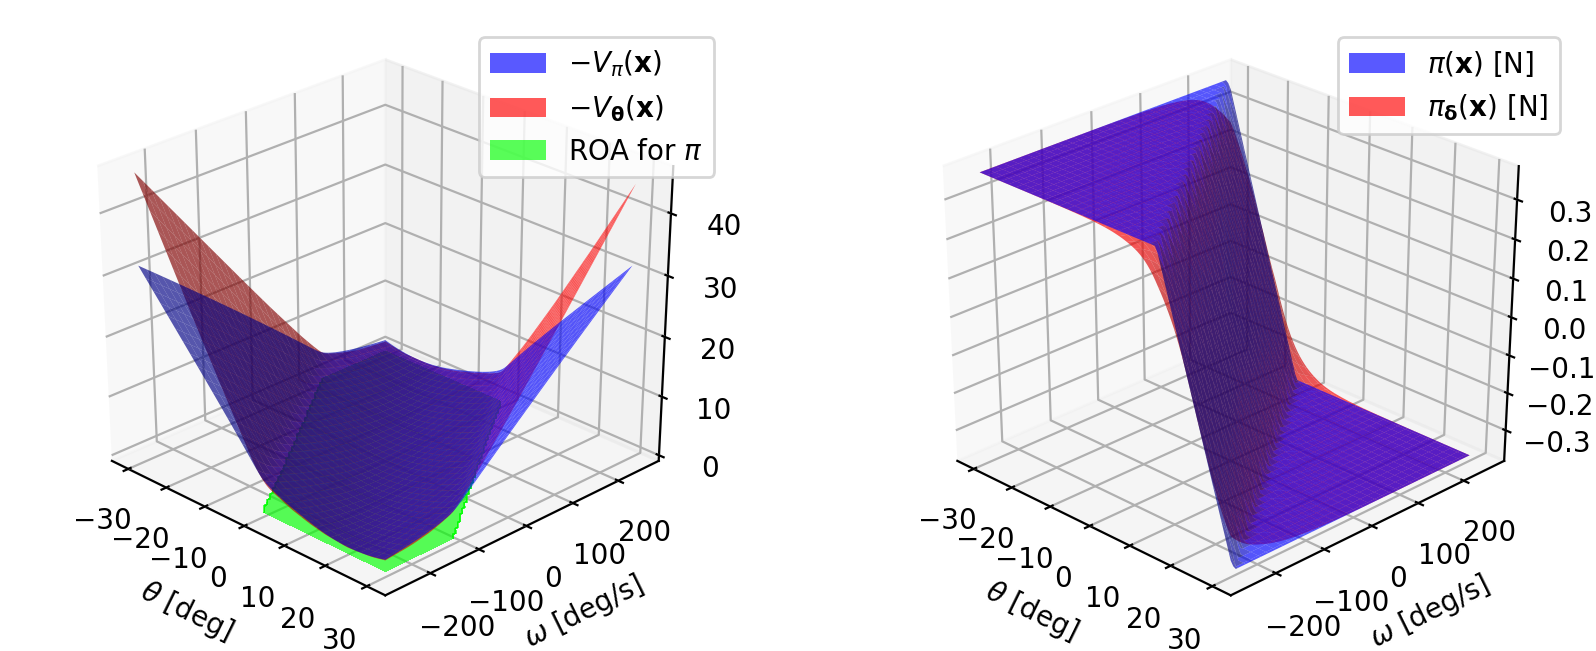

In [32]:
fig = plt.figure(figsize=(10, 4), dpi=OPTIONS.dpi)

# Value functions ----------------------------------------------- #
ax = fig.add_subplot(121, projection='3d')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\omega$ [deg/s]')

approx = - values.eval({states: grid.all_points}).reshape(grid.num_points)
truth = - true_values.reshape(grid.num_points)
for zz, c in zip([approx, truth], ['r', 'b']):
    surf = ax.plot_surface(xx, yy, zz, color=c, alpha=0.65)
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d

# ROA
z = roa.reshape(grid.num_points)
ax.contourf(xx, yy, z, cmap=binary_cmap('green', 0.65), zdir='z', offset=0)

# Legend
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in [(0., 0., 1., 0.65), (1., 0., 0., 0.65), (0., 1., 0., 0.65)]]    
ax.legend(proxy, [r'$-V_{\pi}({\bf x})$', r'$-V_{\bf \theta}({\bf x})$', r'ROA for $\pi$'])
ax.view_init(None, -45)


# Policies ------------------------------------------------------ #
ax = fig.add_subplot(122, projection='3d')
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\omega$ [deg/s]')

approx = u_max * actions.eval({states: grid.all_points}).reshape(grid.num_points)
truth = u_max * policy_lqr(grid.all_points).eval().reshape(grid.num_points)
for zz, c in zip([approx, truth], ['r', 'b']):
    surf = ax.plot_surface(xx, yy, zz, color=c, alpha=0.65)
    surf._facecolors2d = surf._facecolors3d
    surf._edgecolors2d = surf._edgecolors3d

# Legend
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in [(0., 0., 1., 0.65), (1., 0., 0., 0.65)]]    
ax.legend(proxy, [r'$\pi({\bf x})$ [N]', r'$\pi_{\bf \delta}({\bf x})$ [N]'])
ax.view_init(None, -45)

plt.show()


### New ROA

Visually compare the new ROA yielded by the parametric policy to the one yielded by the LQR policy, possibly with saturation constraints.

In [33]:
closed_loop_dynamics = lambda x: future_states.eval({states: x})
roa_horizon = 800
tol = 0.01
new_roa, new_trajectories = compute_roa(grid, closed_loop_dynamics, roa_horizon, tol, equilibrium=None, no_traj=False)


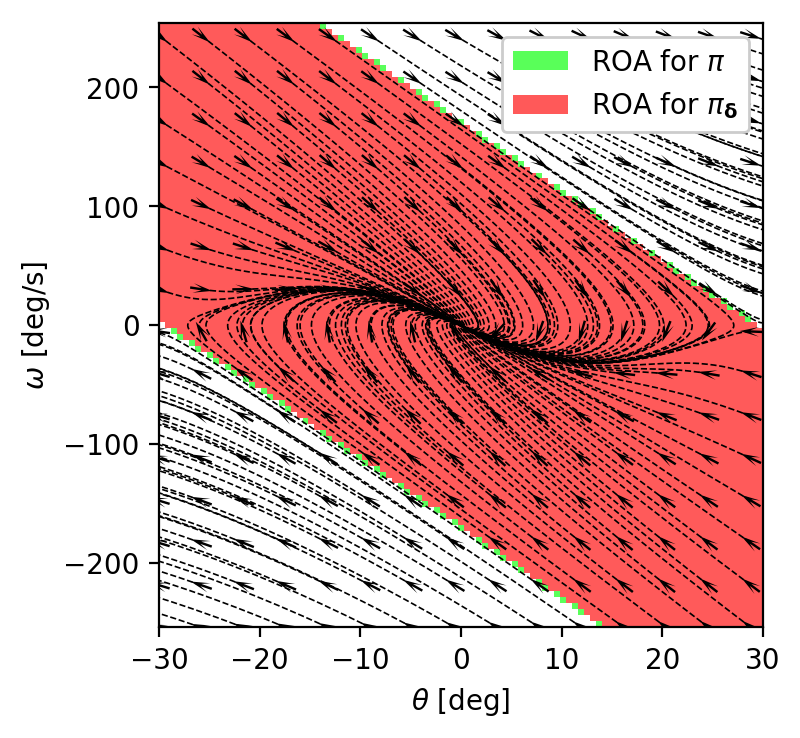

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=OPTIONS.dpi)

norms = np.rad2deg(state_norm)
plot_limits = np.column_stack((- norms, norms))
ax.set_aspect(norms[0] / norms[1])
ax.set_xlim(plot_limits[0])
ax.set_ylim(plot_limits[1])
ax.set_xlabel(r'$\theta$ [deg]')
ax.set_ylabel(r'$\omega$ [deg/s]')
    
# Compare ROAs
cmap = ListedColormap([(1., 1., 1., 0.), (0., 1., 0., 0.65), (1., 0., 0., 0.65)])
z = (roa.astype(int) + new_roa.astype(int)).reshape(grid.num_points)
im = ax.imshow(z.T, origin='lower', extent=plot_limits.ravel(), aspect=norms[0] / norms[1], cmap=cmap)

# Sub-sample discretization for faster and clearer plotting
N_traj = 13
skip = int(grid.num_points[0] / N_traj)
sub_idx = np.arange(grid.nindex).reshape(grid.num_points)
sub_idx = sub_idx[::skip, ::skip].ravel()
sub_trajectories = new_trajectories[sub_idx, :, :]

# Trajectories
for n in range(sub_trajectories.shape[0]):
    theta = sub_trajectories[n, 0, :] * norms[0]
    omega = sub_trajectories[n, 1, :] * norms[1]
    ax.plot(theta, omega, 'k--', linewidth=0.6)
sub_states = grid.all_points[sub_idx]
dx_dt = (future_states.eval({states: sub_states}) - sub_states) / dt
dx_dt = dx_dt / np.linalg.norm(dx_dt, ord=2, axis=1, keepdims=True)
ax.quiver(sub_states[:, 0] * norms[0], sub_states[:, 1] * norms[1], dx_dt[:, 0], dx_dt[:, 1], scale=None, pivot='mid', headwidth=4, headlength=8, color='k')

# Legend
proxy = [plt.Rectangle((0,0), 1, 1, fc=c) for c in [(0., 1., 0., 0.65), (1., 0., 0., 0.65)]]    
legend = ax.legend(proxy, [r'ROA for $\pi$', r'ROA for $\pi_{\bf \delta}$'], loc='upper right')
legend.get_frame().set_alpha(1.)

plt.show()
